# 10. Principles of the Bayesian History Matching technique

This example shows how to determine the model parameter $\mathbf{x}$ for a model $y=f(\mathbf{x})$ when output values $\hat{y}$  are known. 
History matching technique consists in drawing a number N of samples from the parameter space: $\mathbf{x}_i\sim p(\mathbf{x})$, solving the model $y_i=f(\mathbf{x}_i)$, computing a discrepancy $d=\frac{\|\hat{y}-y_i\|}{\sigma_i}$ and retaining all the samples such that $d\geq toll$.
Generally, solving $y=f(\mathbf{x})$ can be computally intensive; in this example, we replace $f(\mathbf{x})$ with a Gaussian Process surrogate.

In [16]:
import numpy as np
import torch

In [17]:
# enforce reproducibility
from GPErks.utils.random import set_seed
from GPErks.constants import DEFAULT_RANDOM_SEED
seed = DEFAULT_RANDOM_SEED
set_seed(seed)

<br/>

**2D ellliptic paraboloid**:

$f(x) = \left(\frac{x_{1}}{a}\right)^2 + \left(\frac{x_{2}}{a}\right)^2\;\;\; a=b=1$

<br/>


In [18]:
# define deterministic function
def f(x):  # elliptic paraboloid: y = x1^2/a^2 + x2^2/b^2, with a=b=1
    return np.sum(np.power(x, 2), axis=0)

d = 2  # input dimension (f:2D->1D)

In [19]:
# generate synthetic datum to match by visually exploring the parameter space
n = 100
x = np.linspace(-3, 3, n)
x1, x2 = np.meshgrid(x, x)
x = np.hstack((x1.reshape(n**2, 1), x2.reshape(n**2, 1)))
y = f(x.T).reshape(n, n)

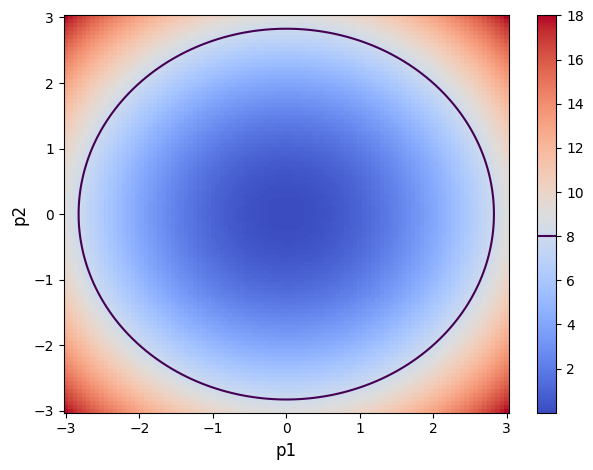

In [20]:
import matplotlib.pyplot as plt
# plot synthetic data, i.e. deterministic function evaluations;
# note: we highlight with a contour plot a specific region of the parameter space where
# the deterministic function evaluates to 8
fig, axis = plt.subplots(1, 1)
pc = axis.pcolormesh(x1, x2, y, cmap="coolwarm", shading="auto")
c = axis.contour(x1, x2, y, levels=[8.0])
cbar = fig.colorbar(pc, ax=axis)
cbar.add_lines(c)
xlabels = ["p1", "p2"]
axis.set_xlabel(xlabels[0], fontsize=12)
axis.set_ylabel(xlabels[1], fontsize=12)
fig.tight_layout()
plt.show()

In [21]:
# we generate a synthetic experimental datum (mean and var) we aim to match by using history matching
exp_mean = np.array([8.0])
exp_var = 0.1 * exp_mean

We now train a univariate Gaussian process emulator (GPE) to replace the mapping f: X -> y


f dataset loaded.
Notes from the author:
"This dataset was generated by using f function evaluations."
Dataset properties:
-Input size: 2
-Input parameters: ['p1', 'p2']
-Output size: 1
-Output feature: ['y']
-Sample size: 10
-Discrepancy: 0.0049
-Validation data available: Yes (size = 10)
-Testing data available: Yes (size = 20)


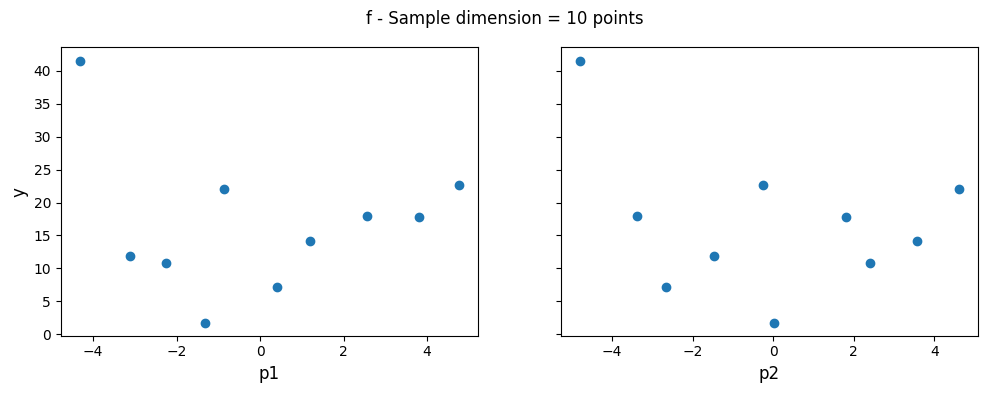

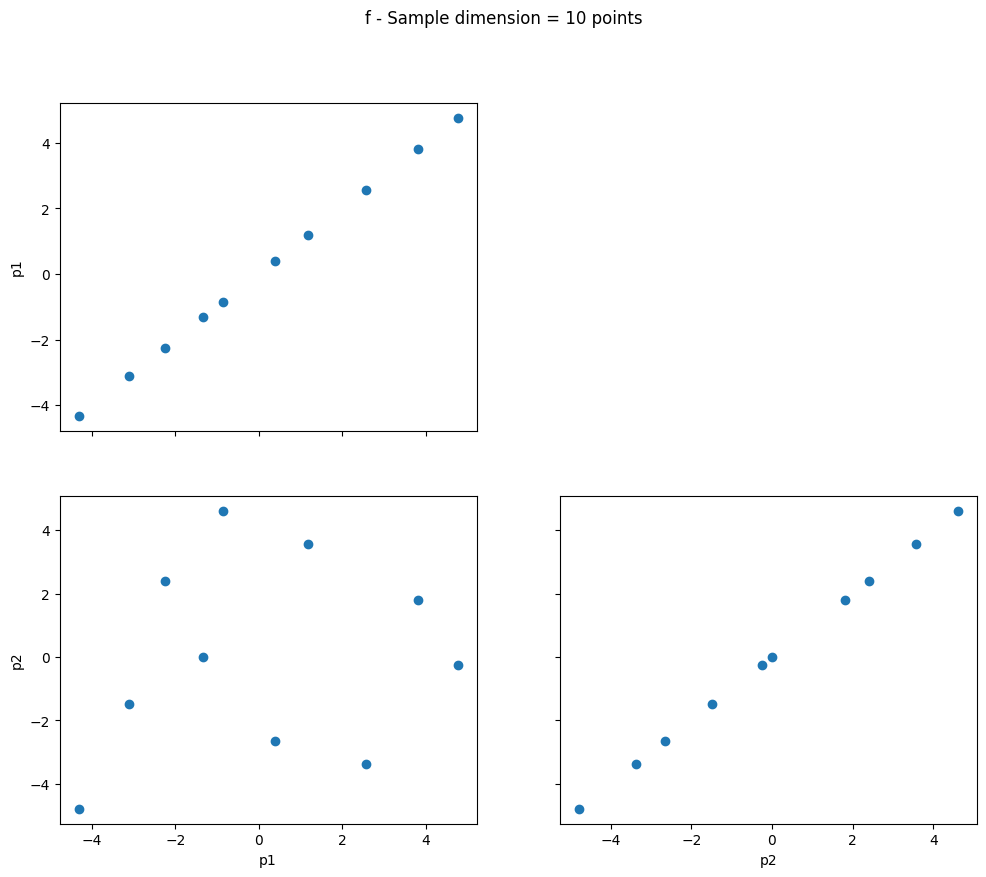

In [22]:
# build dataset
from GPErks.gp.data.dataset import Dataset

dataset = Dataset.build_from_function(
    f,
    d,
    n_train_samples=10,
    n_val_samples=10,
    n_test_samples=20,
    design="lhs",
    seed=seed,
    x_labels=xlabels,
    l_bounds=[-5, -5],
    u_bounds=[5, 5],  # note: we take a larger parameter range for the training dataset
)
dataset.summary()
dataset.plot()
dataset.plot_pairwise()

In [23]:
# choose likelihood, mean function and covariance function
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood

from GPErks.gp.mean import LinearMean

likelihood = GaussianLikelihood()
mean = LinearMean(degree=2, input_size=dataset.input_size, bias=True)
covar = ScaleKernel(MaternKernel(ard_num_dims=dataset.input_size))

In [24]:
# choose metrics
from torchmetrics import MeanSquaredError, R2Score

metrics = [MeanSquaredError(), R2Score()]

# define experiment + device
from GPErks.gp.experiment import GPExperiment

experiment = GPExperiment(
    dataset,
    likelihood,
    mean,
    covar,
    metrics=metrics,
    seed=seed,
)
device = "cuda" if torch.cuda.is_available() else "cpu"

INFO:2025-05-16 17:20:07,622:emulator:train_auto:L205: Training emulator...
INFO:2025-05-16 17:20:07,761:emulator:train_auto:L207: Trained emulator.
INFO:2025-05-16 17:20:07,761:emulator:train_auto:L209: Saving model...
INFO:2025-05-16 17:20:07,762:emulator:train_auto:L214: Saved model.


                  Score
MeanSquaredError    0.0
R2Score             1.0


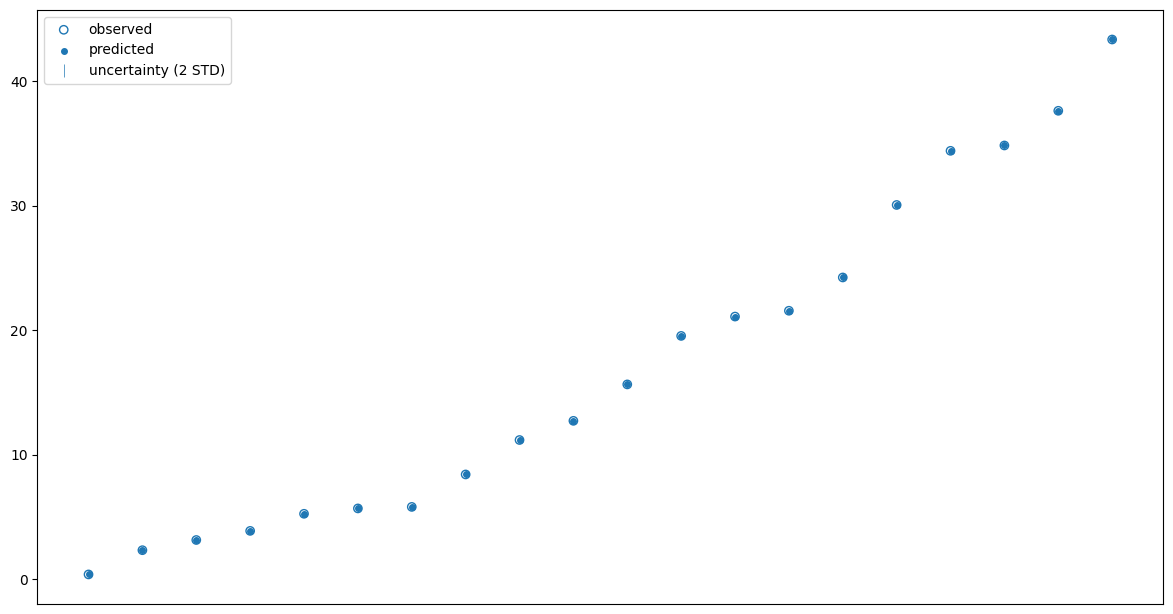

In [25]:
# train emulator
from GPErks.train.emulator import GPEmulator

emulator = GPEmulator(experiment, device)
emulator.train_auto()

# check accuracy
from GPErks.perks.inference import Inference

inference = Inference(emulator)
inference.summary()
inference.plot()

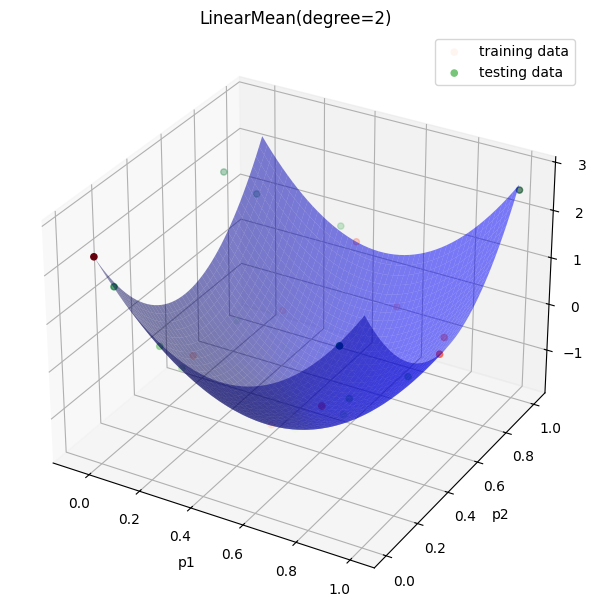

In [26]:
# inspect fitted mean module
# Note: to have an almost perfect emulator, we kind of cheated when selecting degree=2 for the mean function.
# In fact, we knew already that the underlying, deterministic function was an ellipsoid
from GPErks.plot.mean import inspect_mean_module

inspect_mean_module(emulator)

In [27]:
# run the first wave (iteration) of history matching
cutoff = 3.0  # threshold for the implausibility measure
maxno = 1  # the first highest implausibility value (worse emulator prediction) deems a point to be implausible
# Note: maxno is not relevant in this case since we only have 1 emulator to match one experimental datum
from GPErks.utils.array import get_minmax

minmax = get_minmax(
    emulator.experiment.dataset.X_train
)  # training dataset min-max parameter ranges

# perk n.5: Bayesian History Matching technique;
# let's define a wave object
from GPErks.perks.history_matching import Wave

w = Wave(
    emulator=[emulator],
    Itrain=minmax,
    cutoff=cutoff,
    maxno=maxno,
    mean=exp_mean,
    var=exp_var,
)

In [28]:
# create a huge, 100k points parameter space to be explored all at once using the trained emulator
from GPErks.utils.sampling import Sampler

sampler = Sampler(
    design="lhs", dim=d, seed=seed
)  # available designs: 'srs', 'lhs', 'sobol'
n_samples = 100000
x = sampler.sample(
    n_samples,
    l_bounds=list(minmax[:, 0]),
    u_bounds=list(minmax[:, 1]),
)

         #POINTS
TESTS     100000
IMP        80243
NIMP       19757
PERC   19.7570 %


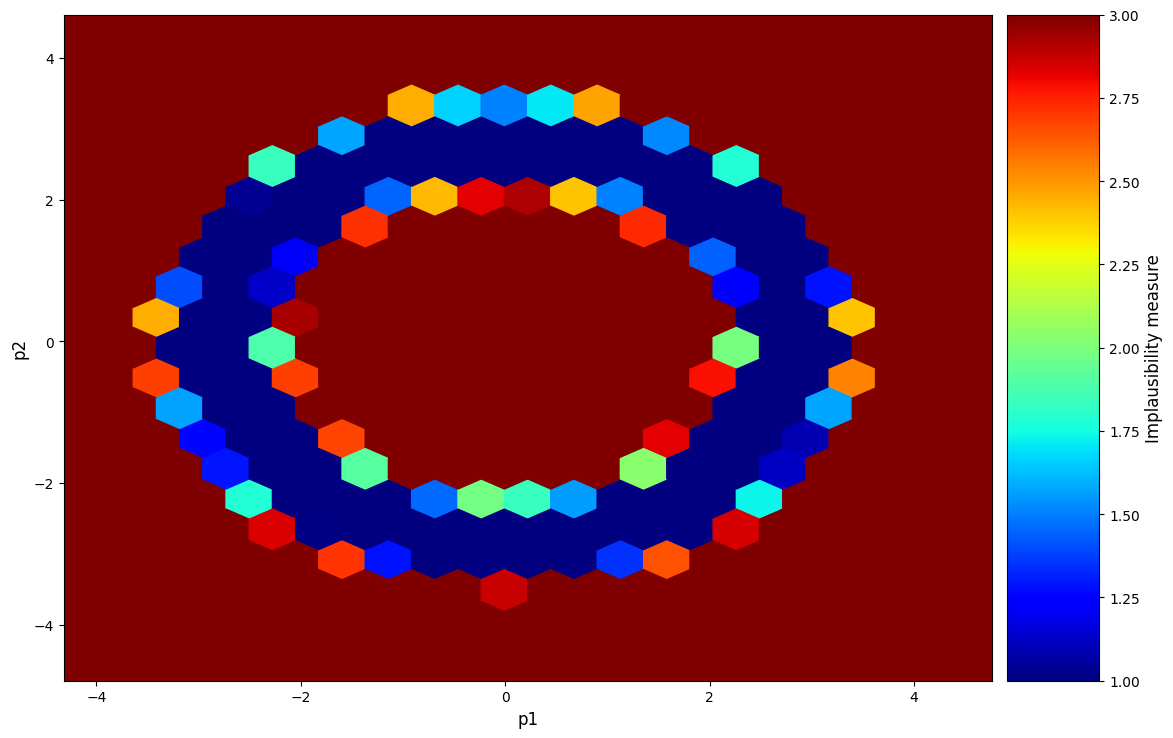

In [29]:
# explore the parameter space to see which parameter points are non-implausible or implausible
# to match the synthetic experimental datum
w.find_regions(x)
w.print_stats()
w.plot_wave(xlabels=xlabels, display="impl")
# Note: the non-implausible region has a circular shape, simular to the 8-value isoline we saw before

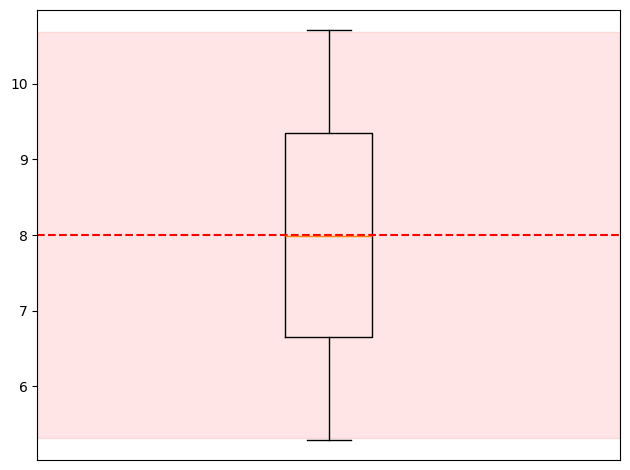

In [30]:
# check that the found non-implausible parameter space is actually compatible with
# matching the syntactic experimental datum by evaluating the true function
y_actual = f(w.NIMP.T)

# plot the actual values' distribution to see if it matches the synthetic experimental datum distribution
fig, axis = plt.subplots(1, 1)
axis.boxplot(y_actual)
axis.axhline(exp_mean, c="r", ls="--")
xmin, xmax = axis.get_xlim()
inf_conf = exp_mean - cutoff * np.sqrt(exp_var)
sup_conf = exp_mean + cutoff * np.sqrt(exp_var)
axis.fill_between([xmin, xmax], inf_conf, sup_conf, color="r", alpha=0.1)
axis.set_xticks([])
fig.tight_layout()
plt.show()